In [1]:
import csv
import googletrans
import seaborn as sns
import matplotlib.pyplot as plt


from collections import Counter
from pandas import DataFrame
from random import sample

### Dataset Paths

In [2]:
TRAIN_ENG="data/train_en.csv"
TRAIN_TCN="data/train_tcn.csv"
DEV_ENG="data/dev_en.csv"
DEV_TCN="data/dev_tcn.csv"
TEST_TCN="data/test_tcn.csv"

### Data Denoise and Collection

Dataset contains very poor and inconsistent handling of double quotes. For the ENG datasets, the only real value of the double quote is to indicate 'inches' for measurements in certain contexts. Otherwise, double quotes have no real value and can be removed. The dataset is also not a true CSV, with inconsistent number of columns in the dataset. This problem is also present in the TCN dataset.

After manually analyzing the errors, here's how we can recover most of the broken data:

1. Replace all \" (backslash double quote) with a placeholder.

2. Remove all ", then recover all \"

3. Don't use Python CSV reader, perform manual string splits by commas. Use rfind to find last comma, which indicates the start of the category label, except for the "Toys, Games & Collectibles" category. We handle that as a special case.

4. If line does not have commas, it will be rolled over (prepended) to the next line (this is because actual data is broken over multiple lines, most likely because user had a newline in the input which team did not sanitize)

In [3]:
hardcoded_eng_categories = ["Hobbies & Stationery",
                            "Health & Personal Care",
                            "Mobile Accessories",
                            "Home & Living",
                            "Women's Apparel",
                            "Women Shoes",
                            "Babies & Kids",
                            "Women Accessories",
                            "Toys, Games & Collectibles",
                            "Groceries",
                            "Motors",
                            "Makeup & Fragrances",
                            "Women's Bags",
                            "Men's Apparel",
                            "Pet Care",
                            "Men's Bags & Accessories",
                            "Sports & Travel",
                            "Men Shoes",
                            "Gaming",
                            "Laptops & Computers",
                            "Home Entertainment",
                            "Mobiles & Gadgets",
                            "Cameras",
                            "Home Appliances",
                            "Consumer Electronics",
                            "Digital Goods & Vouchers"]
hardcoded_eng_categories = set(hardcoded_eng_categories)

In [4]:
hardcoded_tcn_categories = ["Health & Beauty",
                            "Game Kingdom",
                            "Life & Entertainment",
                            "Mother & Baby",
                            "Men's Apparel",
                            "Women's Apparel",
                            "Women Bags",
                            "Women Shoes",
                            "Home & Living",
                            "Everything Else",
                            "Hardware & 3C",
                            "Men's Bags& Accessories",
                            "Sports & Outdoors",
                            "Helpbuy",
                            "Men Shoes",
                            "Books",
                            "Motors",
                            "Home Electronic",
                            "Food & Beverages",
                            "Mobile & Gadgets",
                            "Women Accessories",
                            "Pets",
                            "Tickets & Services"]
hardcoded_tcn_categories = set(hardcoded_tcn_categories)

In [5]:
def get_eng_data(filename, categories=hardcoded_eng_categories, LIMIT=-1):

    rows = []
    
    with open(filename) as f:
        
        count = 0
        
        # Ignore header
        next(f)
        
        # Setup rollover
        prev = ""
        
        # Iterate over lines
        for line in f:
            line = prev + " " + line
            line = line.replace('\\"', "<XXX>")
            line = line.replace('"', '')
            line = line.replace("<XXX>", '"').strip()
            
            tokens = line.split(",")
            if len(tokens) == 1: # no commas
                prev = line
                continue
                            
            category = tokens[-1] # Category is the last token
            
            # Check against list of categories so we don't admit nonsense
            if category not in categories:
                            
                # Handle special case            
                if "Games & Collectibles" in category:
                    category = "{}, {}".format(tokens[-2].strip(), tokens[-1].strip())
                    rows.append((",".join(tokens[:-2]), category))
                else:
                    continue                
            else:
                rows.append((",".join(tokens[:-1]), category))
                
            prev = "" # Clear out rollover
                
            count += 1
            
            # Early terminate if specified
            if LIMIT >= 0 and count >= LIMIT:
                break
            
    return rows
    

def get_tcn_data(filename, categories=hardcoded_tcn_categories, LIMIT=-1):
    
    rows = []
    
    with open(filename) as f:
        
        count = 0
        
        # Ignore header
        next(f)
        
        # Setup rollover
        prev = ""
        
        # Iterate over lines
        for line in f:
            
            line = prev + line
            comma_index = line.rfind(",")
            if comma_index < 0:
                prev = line
                continue
                                
            category = line[comma_index + 1:].strip() # Category is the last token
            
            
            # Check against list of categories so we don't admit nonsense
            if category not in categories:
                continue

            rows.append((line[:comma_index].strip(), category))
                
            prev = "" # Clear out rollover
                
            count += 1
            
            # Early terminate if specified
            if LIMIT >= 0 and count >= LIMIT:
                break
            
    return rows


def get_generic_data(filename, LIMIT=-1):
    
    rows = []
    
    with open(filename) as f:
        
        count = 0
        
        # Ignore header
        next(f)
        
        # Iterate over lines
        for line in f:
            
            rows.append((line.strip(), "private"))
            count += 1
            
            # Early terminate if specified
            if LIMIT >= 0 and count >= LIMIT:
                break
            
    return rows


In [25]:
# Define a sample size for viewing sample parsing results
SAMPLE_SIZE=10

In [33]:
train_eng_data = get_eng_data(TRAIN_ENG)
for ex in sample(train_eng_data, SAMPLE_SIZE):
    print(ex[0])
print("Read {} examples.".format(len(train_eng_data)))

DC Off Shoulder Blouse
Peach Sleeveless Dress (brand: Philosophy)
Cetaphil hair and body for baby (Authentic)
(Chrome) Universal Motorcycle Air Filter Adjustable
PRIMA WATERCOLOR CONFECTIONS - WOODLANDS
Soft Wired Hair Wrap
airpods pro case peaceminusone GD earphone cover silicone
ORIGINAL TRIBAL HOODIE TOP
heart evangelista embroidered jacket
Brand New Branded Shoes for Infants & Toddlers
Read 503193 examples.


In [34]:
train_tcn_data = get_tcn_data(TRAIN_TCN)
for ex in sample(train_tcn_data, SAMPLE_SIZE):
    print(ex[0])
print("Read {} examples.".format(len(train_tcn_data)))

★現貨上市★🎈 愛心圖案情侶鞋 百搭小白鞋 正韓時尚低幫男鞋女鞋 板鞋
女童。短襪。貓咪襪子
運動藍牙耳機雙耳無線跑步頸掛脖式入耳式超長待機續航掛耳式oppo
【新森活家具】《瑪丹娜》雙人加大 L型沙發床  沙發床 咖啡紫 北歐風 亞麻布 布沙發 鐵腳 簡約風 非 ikea
孕婦枕哺乳枕頭喂奶枕護腰横抱婴兒躺喂神器寶寶侧睡四季通用懒人哺乳枕
客單：羅淑
7月~直筒割破寬闊腿牛仔褲，下盤肉肉必敗款
WMNS NIKE AIR MAX 95 正品 白 灰 深藍 橘黃 桃紅
正版 雷標 名偵探柯南 工藤新一 坐姿款 12吋 毛利小五郎 毛利蘭
ghd platinum+新白金造型夾（台版）
Read 500295 examples.


In [35]:
dev_eng_data = get_generic_data(DEV_ENG)
for ex in sample(dev_eng_data, SAMPLE_SIZE):
    print(ex[0])
print("Read {} examples.".format(len(dev_eng_data)))

Augelute Kids Set Home Forest Belly Short Sleeve Set
Japan ambai Snow Pan 14cm - Koizumi and Japan Made ISK - 52014
Airpillow Samsung Note 4 / Note 5 Full Air Cushion Clear Transparent Back Cover
Integrated Forming Road Safety Hat
Attract Fortune No. 75 Premium Moxa Indonesia / Pcs
Ozaki WOW WR325 25W 2.2 Dual Bass Speaker
Flamingo Flower Glass Phone Case S9/S9+/J7+/s7 edge/J7Prime/NOTE8/A8 2018
Japan kalita Red Brass coffee spoon 10g
Coach Full Leather Flip Magnetic Snap Leisure Oblique Backpack
"12 ""Super Bright Luminous Stereo Convex word Mute Clock 0737"
Read 1000 examples.


In [36]:
dev_tcn_data = get_tcn_data(DEV_TCN, categories=set(["private", "public"]))
for ex in sample(dev_tcn_data, SAMPLE_SIZE):
    print(ex[0])
print("Read {} examples.".format(len(dev_tcn_data)))

嬰幼兒短褲 嬰兒褲子 寶寶短褲 童裝 UG40523 好娃娃
情趣純白亮面三件式護士角色扮演服 白【AB01619】i-style
PENTEL K600金屬鋼珠筆
顏文字小香蕉 鑰匙掛飾 紓壓小物 手機吊飾
CRYSTAL BALL ( GALSIA MARKEZ Crown Canvas Tote Bag )
火烈鸟 花儿 玻璃镜面 手机壳 S9/S9+/J7+/s7 edge/J7Prime/NOTE8/A8 2018 吊饰孔
法國水漾-頂級魚鱗膠原蛋白水蜜桃口味
ORIENT 東方錶 DATEⅡ機械錶 FAC0000DD
施德樓 MS229NC12 快樂學園加寬型蠟筆十二色組/盒
德一 卡賀方塊酥袋裝300G
Read 1000 examples.


In [32]:
test_tcn_data = get_eng_data(TEST_TCN, categories=set(["private", "public"]))
for ex in sample(test_tcn_data, SAMPLE_SIZE):
    print(ex[0])
print("Read {} examples.".format(len(test_tcn_data)))

後背包 艾杜紗質感皮革後背包-Joanna Shop
mt 2017 Summer Basic & Deco 系列全包組
PolarStar 中性 鋪棉連帽保暖外套『灰綠』 P18217
MONA FREMA 荷麗美加 HAG萬倍吸水玻尿酸 100ml
男童拖鞋 POLI波力授權正版拖鞋 魔法Baby~sa71026
派克 PARKER IM 經典高尚系列 霧黑金夾 原子筆 P011882
SKECHERS GO WALK 健走系列 女 13800CHAR
兩件套嬰幼兒童童裝無袖短褲
Gucci Guilty Diamond 罪愛 鑽石限量版 男性淡香水 90ml
復古 電動 iPhone8 iPhone7 6s Plus i6 i7 i8 手機殼
Read 10000 examples.


### Category Analysis

Brief look at the distribution of categories for products. Note that categories were only provided for the initial two training ENG and TCN datasets. The new dev datasets and the test datasets effectively have no category labels, so YMMV.

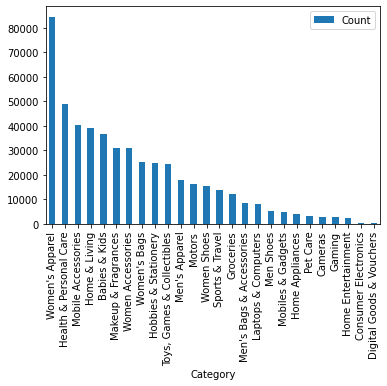

In [12]:
# Training English Categories
train_eng_categories = Counter(list(zip(*train_eng_data))[1])
train_eng_categories_df = DataFrame(sorted(train_eng_categories.items(), key=lambda x: x[1], reverse=True), columns=["Category", "Count"])
train_eng_categories_df.plot(kind="bar", x="Category")

plt.show()

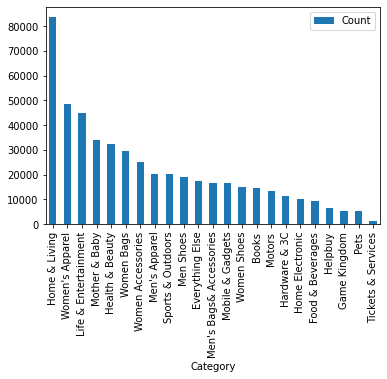

In [13]:
# Training Chinese Categories
train_tcn_categories = Counter(list(zip(*train_tcn_data))[1])
train_tcn_categories_df = DataFrame(sorted(train_tcn_categories.items(), key=lambda x: x[1], reverse=True), columns=["Category", "Count"])
train_tcn_categories_df.plot(kind="bar", x="Category")

plt.show()

### Attempts at Direct Translation Using Google Translate

In [14]:
from googletrans import Translator

In [15]:
translator = Translator()

In [21]:
for ex in sample(train_tcn_data, 20):
    print(ex[0] + " -> " + translator.translate(ex[0], dest="en").text)

現貨 全新 氣質典雅 天然小翡翠 925銀 活圍戒 003 -> Spot new temperament elegant natural small jadeite 925 silver live ring 003
【售】若終究沒有永遠，每個有你的瞬間都多一點(親簽版) -> [Sale] If not forever, every moment you have a little more (pro-signature version)
【飛越家私】北歐茶幾電視柜組合2020新款輕奢茶桌客廳家用桌子簡約現代正方形 -> [Fly over furniture] Nordic coffee table TV cabinet combination 2020 new light luxury tea table living room home table simple modern square
14AW C.E CAVEMPT BOX LOGO 兩袖拼接帽衫連帽 長袖 衛衣 -> 14AW C.E CAVEMPT BOX LOGO two-sleeve stitching hoodie hooded long-sleeved sweater
現貨～超好寫可愛雙色筆（藍、紅） -> Spot ~ Super easy to write cute two-color pen (blue, red)
偉誠蔘藥行—羅漢果茶10入《現貨24hr內出貨》 -> Weicheng Ginseng Medicine Co., Ltd.-Luohan Guocha 10 into "Spot Delivery within 24hr"
SK 世鎧精密 M5 工作長100mm SDS-PLUS 四溝水泥鑽頭 三刃 -> SK Shijia Precision M5 100mm working length SDS-PLUS four-groove cement drill bit three-edged
Puma Suede平台跑步運動鞋 -> Puma Suede platform running sneakers
iPhone SE2 X XS Max XR 8 7 6 Plus 軟萌創意微立體汪寵軟殼手機殼 -> iPhone SE2 X XS Max XR 8 7 6 Pl

In [37]:
test_translations = []
for ex in test_tcn_data:
    test_translations.append(translator.translate(ex[0], dest="en"))

KeyboardInterrupt: 

In [23]:
len(test_tcn_data)

3000